# Explicit Range Kutta Method

CBE 20258. Numerical and Statistical Analysis. Spring 2020.

&#169; University of Notre Dame

Reference: Chapter 17 in McClarren.

## Learning Objectives

After studying this notebook, completing the activties, and attending class, you should be able to:
* Compare Runge-Kutta to the other three methods.
 * Error convergence rate
 * Stability (how does this relate to explicit versus implicit?)
 * Ease to implement, computational expense (how does this relate to explicit versus implicit?)

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import scipy.integrate as integrate

## Fourth-order (Explicit) Runge-Kutta Method

There is one more method that we need to consider at this point.  It is an explicit method called a Runge-Kutta method.  The particular one we will learn is fourth-order accurate in $\Delta t$.  That means that if we decrease $\Delta t$ by a factor of 2, the error will decrease by a factor of $2^4=16$. The method can be written as
$$y^{n+1} = y^n + \frac{1}{6}\left(\Delta y_1 + 2 \Delta y_2 + 2 \Delta y_3 + \Delta y_4\right),$$
where
$$\Delta y_1 = \Delta t f(y^n, t^n),$$ $$\Delta y_2 = \Delta t f\left(y^n + \frac{\Delta y_1}{2},t^n + \frac{\Delta t}{2}\right),$$
$$\Delta y_3 =  \Delta t f\left(y^n + \frac{\Delta y_2}{2},t^n + \frac{\Delta t}{2}\right),$$
$$\Delta y_4 =  \Delta t f\left(y^n + \Delta y_3,t^n + \Delta t\right).$$
To get fourth-order accuracy, this method takes a different approach to integrating the right-hand side of the ODE.  Basically it makes several projections forward and combines them in such a way that the errors below $\Delta t^4$ cancel out.

Additional details with a nice illustration: https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods

Implementing this method is not difficult either.


<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Discuss the code below with a partner. Be prepared to share one question or observation with the class after 3 minutes.
</div>

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: Complete the function below. Hint: You should write two lines of Python code. The first line should calculate <tt>dy3</tt> and the second line should calculate <tt>dy4</tt>.
</div>

In [2]:
def RK4(f,y0,Delta_t,numsteps):
    """Perform numsteps of the 4th order Runge-Kutta method starting at y0
    of the ODE y'(t) = f(y,t)
    Args:
        f: function to integrate takes arguments y,t
        y0: initial condition
        Delta_t: time step size
        numsteps: number of time steps
        
    Returns:
        a numpy array of the times and a numpy
        array of the solution at those times
    """
    numsteps = int(numsteps)
    y = np.zeros(numsteps+1)
    t = np.arange(numsteps+1)*Delta_t
    y[0] = y0
    for n in range(1,numsteps+1):
        dy1 = Delta_t * f(y[n-1], t[n-1])
        dy2 = Delta_t * f(y[n-1] + 0.5*dy1, t[n-1] + 0.5*Delta_t)
        # Add your solution here
        y[n] = y[n-1] + 1.0/6.0*(dy1 + 2.0*dy2 + 2.0*dy3 + dy4)
    return t, y

We'll test this on our problem with a simple exponential solution.

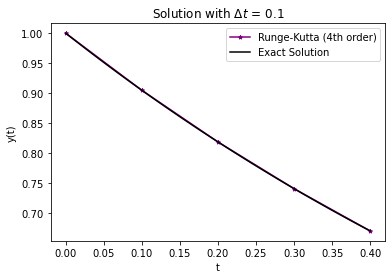

Time 0.0  :  1.0
Time 0.1  :  0.9048375
Time 0.2  :  0.8187309014062499
Time 0.3  :  0.7408184220011776
Time 0.4  :  0.6703202889174906


In [3]:
RHS = lambda y,t: -y
Delta_t = 0.1
t_final = 0.4
t,y = RK4(RHS,1,Delta_t,t_final/Delta_t)
plt.plot(t,y,'-',label="Runge-Kutta (4th order)",color="purple",marker="*",markersize=4)
t_fine = np.linspace(0,t_final,100)
plt.plot(t_fine,np.exp(-t_fine),label="Exact Solution",color="black")
plt.xlabel("t")
plt.ylabel("y(t)")
plt.legend()
plt.title("Solution with $\Delta t$ = " + str(Delta_t))
plt.show()
for i in range(len(t)):
    print("Time",round(t[i],1)," : ",y[i])

Your function in the last home activity works if it computes the following values:

| t | y |
| - | - |
| 0.0 | 1.0 |
| 0.1 | 0.9048375 |
| 0.2 | 0.8187309 |
| 0.3 | 0.74081842 |
| 0.4 | 0.67032029 |

In [4]:
# Removed autograder test. You may delete this cell.

Run the cell below to plot Range-Kutta with different step sizes.

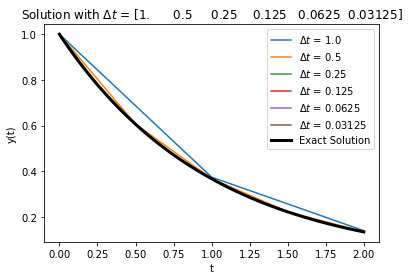

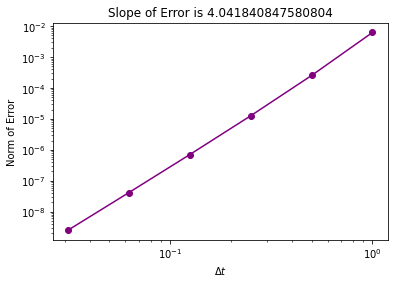

In [5]:
RHS = lambda y,t: -y
Delta_t = np.array([1.0,.5,.25,.125,.0625,.0625/2])
t_final = 2
error = np.zeros(Delta_t.size)
t_fine = np.linspace(0,t_final,100)
count = 0
for d in Delta_t:
    t,y = RK4(RHS,1,d,t_final/d)
    plt.plot(t,y,label="$\Delta t$ = " + str(d))
    error[count] = np.linalg.norm((y-np.exp(-t)))/np.sqrt(t_final/d)
    count += 1
plt.plot(t_fine,np.exp(-t_fine),linewidth=3,color="black",label="Exact Solution")
plt.xlabel("t")
plt.ylabel("y(t)")
plt.legend()
plt.title("Solution with $\Delta t$ = " + str(Delta_t))
plt.show()
plt.loglog(Delta_t,error,'o-',color="purple")
slope = (np.log(error[-1]) - np.log(error[-2]))/(np.log(Delta_t[-1])- np.log(Delta_t[-2]))
plt.title("Slope of Error is " + str(slope))
plt.xlabel("$\Delta t$")
plt.ylabel("Norm of Error")
plt.show()

Yes, we do indeed get 4th order convergence, as the name **fourth-order Runge-Kutta** suggests.

We can also try this on our more complicated problem.

First run the cell below with Crank-Nicolson to use in the following example.

In [6]:
def inexact_newton(f,x0,delta = 1.0e-7, epsilon=1.0e-6, LOUD=False):
    """Find the root of the function f via Newton-Raphson method
    Args:
        f: function to find root of
        x0: initial guess
        delta: finite difference parameter
        epsilon: tolerance
        
    Returns:
        estimate of root
    """
    x = x0
    if (LOUD):
        print("x0 =",x0)
    iterations = 0
    while (np.fabs(f(x)) > epsilon):
        fx = f(x)
        fxdelta = f(x+delta)
        slope = (fxdelta - fx)/delta
        if (LOUD):
            print("x_",iterations+1,"=",x,"-",fx,"/",slope,"=",x - fx/slope)
        x = x - fx/slope
        iterations += 1
    if LOUD:
        print("It took",iterations,"iterations")
    return x #return estimate of root

def crank_nicolson(f,y0,Delta_t,numsteps, LOUD=False):
    """Perform numsteps of the backward euler method starting at y0
    of the ODE y'(t) = f(y,t)
    Args:
        f: function to integrate takes arguments y,t
        y0: initial condition
        Delta_t: time step size
        numsteps: number of time steps
        
    Returns:
        a numpy array of the times and a numpy
        array of the solution at those times
    """
    numsteps = int(numsteps)
    y = np.zeros(numsteps+1)
    t = np.arange(numsteps+1)*Delta_t
    y[0] = y0
    for n in range(1,numsteps+1):
        if LOUD:
            print("\nt =",t[n])
            
        # setup nonlinear system
        solve_func = lambda u: u-y[n-1] - 0.5*Delta_t*(f(u,t[n])
                                                       + f(y[n-1],t[n-1]))
        # solve nonlinear system
        y[n] = inexact_newton(solve_func,y[n-1])
        
        if LOUD:
            print("y =",y[n])
    return t, y

Run the following cell to compare RK-4 and Crank-Nicolson with a step size of 0.25.

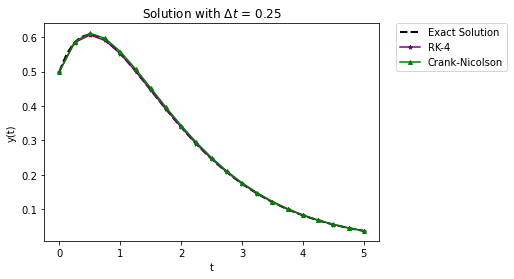

In [7]:
RHS = lambda y,t: (1/(t+0.5)-1)*y
exact_sol = lambda t: (t+0.5)*np.exp(-t)
Delta_t = 0.25
t_final = 5
t_fine = np.linspace(0,t_final,100)

plt.plot(t_fine,exact_sol(t_fine),label="Exact Solution",
         linewidth = 2,linestyle="--",color="black")

t,y = RK4(RHS,0.5,Delta_t,t_final/Delta_t)
plt.plot(t,y,label="RK-4",color="purple",marker="*",markersize=4)

t,y = crank_nicolson(RHS,0.5,Delta_t,t_final/Delta_t)
plt.plot(t,y,label="Crank-Nicolson",color="green",marker="^",markersize=4)
plt.xlabel("t")
plt.ylabel("y(t)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Solution with $\Delta t$ = " + str(Delta_t))
plt.show()

Run the following cell to compare RK-4 and Crank-Nicolson with a step size of 0.5.

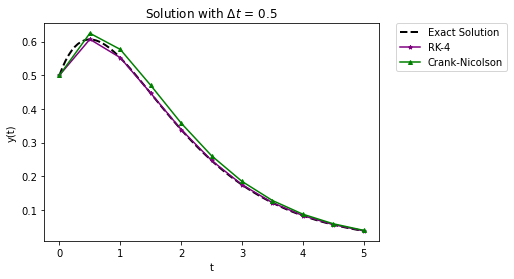

In [8]:
RHS = lambda y,t: (1/(t+0.5)-1)*y
exact_sol = lambda t: (t+0.5)*np.exp(-t)
Delta_t = 0.5
t_final = 5
t_fine = np.linspace(0,t_final,100)

plt.plot(t_fine,exact_sol(t_fine),label="Exact Solution",
         linewidth = 2,linestyle="--",color="black")

t,y = RK4(RHS,0.5,Delta_t,t_final/Delta_t)
plt.plot(t,y,label="RK-4",color="purple",marker="*",markersize=4)

t,y = crank_nicolson(RHS,0.5,Delta_t,t_final/Delta_t)
plt.plot(t,y,label="Crank-Nicolson",color="green",marker="^",markersize=4)

plt.xlabel("t")
plt.ylabel("y(t)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Solution with $\Delta t$ = " + str(Delta_t))
plt.show()

It also seems to do better that Crank-Nicolson with a large time step, but since it is an explicit method, there are limits: with a large enough time step the solution will oscillate and can be unstable. Below the plot shows a comparison with a larger step size of 4.0.

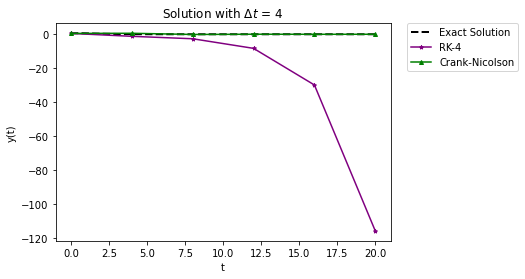

In [9]:
RHS = lambda y,t: (1/(t+0.5)-1)*y
exact_sol = lambda t: (t+0.5)*np.exp(-t)
Delta_t = 4
t_final = 20
t_fine = np.linspace(0,t_final,100)

plt.plot(t_fine,exact_sol(t_fine),label="Exact Solution",
         linewidth = 2,linestyle="--",color="black")

t,y = RK4(RHS,0.5,Delta_t,t_final/Delta_t)
plt.plot(t,y,'-',label="RK-4",color="purple",marker="*",markersize=4)

t,y = crank_nicolson(RHS,0.5,Delta_t,t_final/Delta_t)
plt.plot(t,y,'-',label="Crank-Nicolson",color="green",marker="^",markersize=4)

plt.xlabel("t")
plt.ylabel("y(t)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Solution with $\Delta t$ = " + str(Delta_t))
plt.show()

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Discuss with a partner: Why should you use RK4? When should you use Crank-Nicolson?
</div>